# Tugas xgboost2

Raihana Fawaz (1103210102)

Learn on how to build and optimize model with **gradient boosting.**

#Introduction
By definition, **ensemble methods** combine the predictions of several models (e.g., several trees, in the case of random forest).

Now, we'll learn about another ensemble method called gradient boosting.

#Difference of Decision Tree, Random Forest, and XGBoost

1. Decision Tree:
A decision tree is a simple and interpretable model that recursively splits the data into subsets based on the feature values. It forms a tree-like structure where each internal node represents a test on a feature, each branch represents the outcome of that test, and each leaf node represents the final prediction. The decision tree makes binary decisions at each node to split the data. It is prone to overfitting, especially when the tree becomes deep, capturing noise and leading to poor generalization on unseen data.

2. Random Forest:
Random Forest is an ensemble learning method that builds multiple decision trees and combines their predictions through voting (for classification) or averaging (for regression). Each decision tree is trained on a random subset of the data (bootstrap sample) and a random subset of the features. This randomness reduces overfitting and increases the model's ability to generalize to new data.

3. XGBoost (Extreme Gradient Boosting):
XGBoost is an optimized implementation of the Gradient Boosting algorithm. It creates an ensemble of weak learners (usually shallow decision trees) sequentially, where each new model corrects the errors made by the previous one. XGBoost uses a gradient-based optimization algorithm to minimize a loss function while adding new trees to the ensemble. It also includes regularization terms to control overfitting and speed up the training process. XGBoost is known for its high performance, scalability, and efficiency, making it popular in various machine learning competitions and real-world applications.
**XGBoost** is an implementation of gradient boosting with several additional features focused on perfmance and speed. The final result of an XGBoost model is a weighted sum of the predictions made by all the individual trees in the sequence. The contribution of each tree is adjusted during training based on how well it reduces the overall error.


Note:

* Regularization (penyederhanaan): XGBoost introduces regularization terms to control overfitting during the training process. Regularization helps prevent the model from becoming too complex and ensures better generalization to unseen data.


#Gradient Boosting

**Gradient boosting** is a method that goes through cycles to iteratively add models into an ensemble (setelan).

It begins by initializing the ensemble with a single model, whose predictions can be pretty naive. (Even if its predictions are wildly inaccurate, subsequent (kemudian) additions to the ensemble will address those errors.)

Then, we start the cycle:
1. First, we use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we **add the predictions from all models** in the ensemble.
2. These predictions are used to calculate a loss function (like mean squared error, for instance).
3. Then, we use the loss function to fit a new model that will be added to the ensemble. Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss.
4. Finally, we add the new model to ensemble, and ...
5. Repeat!

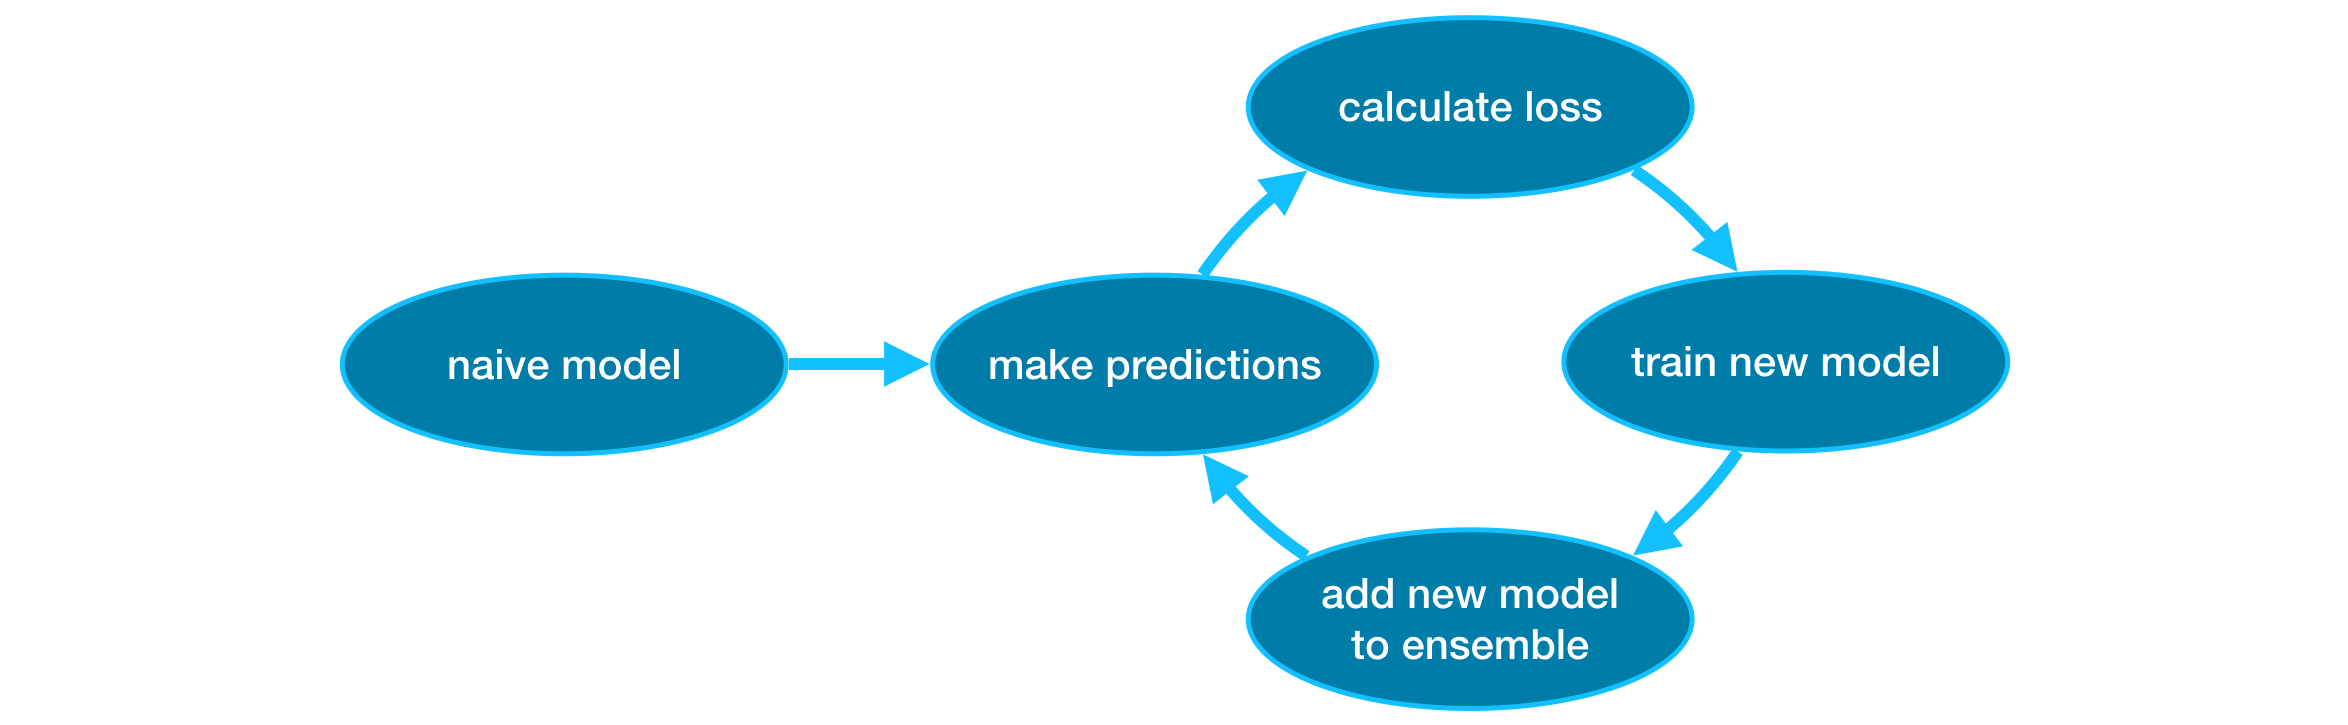

#Example
We begin by loading the training and validation data in X_train, X_valid, y_train, y_valid.

**Prompt:**

Write a code cell to mount Google Drive in Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Prompt:**

Write a code cell to read a CSV file from Google Drive into a DataFrame.

In [2]:
import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Read CSV file into DataFrame
file_path = '/content/drive/MyDrive/Colab Notebooks/tugasxgboost2.csv'  # Ganti dengan path file CSV Anda
df = pd.read_csv(file_path)

# Tampilkan beberapa baris pertama DataFrame
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,"fixed acidity;""volatile acidity"";""citric acid"";""residual sugar"";""chlorides"";""free sulfur dioxide"";""total sulfur dioxide"";""density"";""pH"";""sulphates"";""alcohol"";""quality"""
0,7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6
1,6.3;0.3;0.34;1.6;0.049;14;132;0.994;3.3;0.49;9...
2,8.1;0.28;0.4;6.9;0.05;30;97;0.9951;3.26;0.44;1...
3,7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4...
4,7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4...


**Input library**

In [3]:
# Mengimpor library yang diperlukan
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt

# Install shap if not already installed
!pip install shap

import shap # Import shap after installation
from sklearn.inspection import PartialDependenceDisplay

**Prompt:**

Write a code cell to select a subset of predictors ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt'] and set the target variable ['Price'] from the DataFrame.

In [8]:
# Reload the dataset with the correct separator (semicolon)
df = pd.read_csv(file_path, sep=';')

# Display the first few rows and column names to confirm successful separation
initial_rows_corrected = df.head()
cleaned_columns_corrected = df.columns.tolist()

# Define feature and target columns after correct loading
predictors = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
              'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
              'pH', 'sulphates', 'alcohol']
target = 'quality'

# Separate features (X) and target (y) again
X = df[predictors]
y = df[target]

{
    "initial_rows_corrected": initial_rows_corrected,
    "cleaned_columns_corrected": cleaned_columns_corrected,
    "X_shape": X.shape,
    "y_shape": y.shape
}


{'initial_rows_corrected':    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
 0            7.0              0.27         0.36            20.7      0.045   
 1            6.3              0.30         0.34             1.6      0.049   
 2            8.1              0.28         0.40             6.9      0.050   
 3            7.2              0.23         0.32             8.5      0.058   
 4            7.2              0.23         0.32             8.5      0.058   
 
    free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
 0                 45.0                 170.0   1.0010  3.00       0.45   
 1                 14.0                 132.0   0.9940  3.30       0.49   
 2                 30.0                  97.0   0.9951  3.26       0.44   
 3                 47.0                 186.0   0.9956  3.19       0.40   
 4                 47.0                 186.0   0.9956  3.19       0.40   
 
    alcohol  quality  
 0      8.8        6  


Nama kolom setelah pembersihan: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality'].

**Prompt:**

Write a code cell to split the data into training and validation

In [10]:
# Memisahkan fitur (X) dan target (y)
X = df[predictors]
y = df[target]

# Membagi data menjadi set pelatihan dan set validasi
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)


In the next code cell, we import the scikit-learn API for XGBoost (`xgboost.XGBRegressor`). As you'll see in the output, the `XGBRegressor` class has many tunable parameters.


**Prompt:**

Write a code cell to train the model using XGBoost, and print the mean absolute error on the validation set.

In [11]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Train the model using XGBoost
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_valid)

# Calculate the mean absolute error on the validation set
mae = mean_absolute_error(y_valid, y_pred)

# Print the mean absolute error
print(f"Mean Absolute Error on the validation set: {mae:.2f}")


Mean Absolute Error on the validation set: 0.22


We also make predictions and evaluate the model.

#Parameter Tuning
XGBoost has a few parameters that can dramatically affect accuracy and training speed. The first parameters you should understand are:

`n_estimators`
Specifies how many times to go through the modeling cycle described above. It is equal to the number of models that we include in the ensemble.
* Too low a value causes underfitting, which leads to inaccurate predictions on both training data and test data.
* Too high a value causes overfitting, which causes accurate predictions on training data, but inaccurate predictions on test data (which is what we care about).

Typical values range from 100-1000, though this depends a lot on the `learning_rate` parameter discussed below.

Here is the code to set the number of models in the ensemble:

**Prompt:**

Write a code cell to create another XGBRegressor with 500 estimators, train it, and print the mean absolute error on the validation set.

In [12]:
# Create an XGBRegressor with 500 estimators
model_500 = XGBRegressor(n_estimators=500, random_state=42)
model_500.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_500 = model_500.predict(X_valid)

# Calculate the mean absolute error on the validation set
mae_500 = mean_absolute_error(y_valid, y_pred_500)

# Print the mean absolute error
print(f"Mean Absolute Error on the validation set (500 estimators): {mae_500:.2f}")


Mean Absolute Error on the validation set (500 estimators): 0.09


The MAE result of the model with n_estimators set to 500 turned out to be greater than the default value of n_estimators, which is 100.

The MAE (Mean Absolute Error) of the model with an n_estimators value of 110 turns out to be smaller than the default n_estimators value of 100, as well as n_estimators with a value of 500.

`early_stopping_rounds`
offers a way to automatically find the ideal value for `n_estimators`. Early stopping causes the model to stop iterating when the validation score stop improving, even if we aren't the hard stop for `n_estimators`. It's smart to set a high value for `n_estimators` and then use `early_stopping_rounds` to find the optimal time to stop iterating.

Since random chance sometimes causes a single round where validation scores don't improve, you need to specify a number for how many rounds of straight deterioration (keburukan) to allow before stopping. Setting `early_stopping_rounds=5` is a reasonable choice. In this case, we stop after 5 straight rounds of deteriorating validation scores.

When using `early_stopping_rounds`, you also need to set aside some data for calculating the validation scores. This is done by setting the `eval_set` parameter.

We can modify the example above to include early stopping.

---
Note:

* In the context of training machine learning models, "deteriorating" refers to a situation where the performance of the model on a validation dataset worsens over consecutive iterations during the training process. Typically, we monitor a metric (such as accuracy, mean squared error, etc.) on the validation dataset to evaluate the model's performance.

* In the given code, verbose=False is an argument passed to the fit method of the XGBRegressor model. Setting verbose to False means that during the training process, the model will not produce any output or progress messages. It will train silently without displaying information about each boosting round.

`n_jobs`

On larger datasets where runtime is a consideration, you can use parallelism to build your model faster. It's common to set the parameter `n_jobs` equal to the number of cores on your machine. On smaller datasets, this won't help.
The resulting model won't be any better, so micro-optimizing for fitting time is typically nothing but a distraction. But, it's useful in large datasets where you would otherwise spend a long time waiting during the `fit` command.

Here's the modified example.

**Prompt:**

Write a code cell to train an XGBRegressor with a custom learning rate, 90 estimators, and early stopping rounds, and print the mean absolute error on the validation set.

In [13]:
!pip install -U xgboost

In [14]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Create an XGBRegressor with a custom learning rate and 90 estimators
model_custom = XGBRegressor(n_estimators=90, learning_rate=0.05, random_state=42)

# Fit the model without early stopping
model_custom.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

# Make predictions on the validation set
y_pred_custom = model_custom.predict(X_valid)

# Calculate the mean absolute error on the validation set
mae_custom = mean_absolute_error(y_valid, y_pred_custom)

# Print the mean absolute error
print(f"Mean Absolute Error on the validation set (custom model): {mae_custom:.2f}")


Mean Absolute Error on the validation set (custom model): 0.43


# Visualisasi Feature Importance

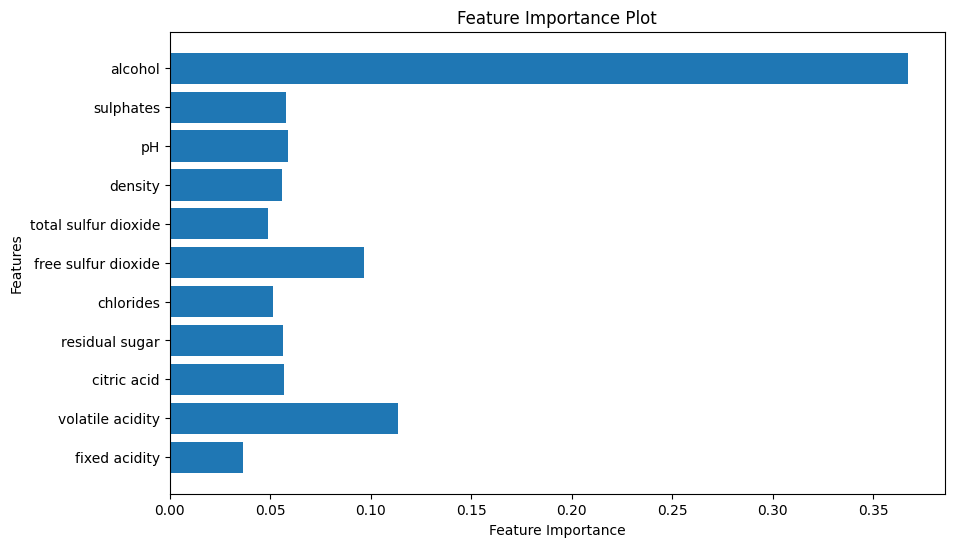

In [16]:
import matplotlib.pyplot as plt

# Membuat plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(predictors, model.feature_importances_)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Plot")
plt.show()

- Fitur dengan kontribusi tinggi seperti 'alcohol' menunjukkan korelasi positif yang kuat dengan kualitas anggur, yang bisa berarti bahwa anggur dengan kadar alkohol lebih tinggi cenderung memiliki kualitas yang lebih baik.

- Fitur lain seperti 'sulphates' mungkin terkait dengan persepsi kekuatan rasa atau stabilitas anggur, sedangkan 'pH' berperan dalam menunjukkan tingkat keasaman, yang juga dapat memengaruhi rasa dan kualitas keseluruhan.

- Fitur seperti 'density' dan 'total sulfur dioxide' memberikan perspektif tambahan tentang karakteristik fisik dan kandungan pengawet dalam anggur, meskipun efeknya tidak dominan.

- Sebaliknya, fitur yang lebih rendah kontribusinya, seperti 'fixed acidity' dan 'volatile acidity', tetap menambah informasi meski dalam kadar yang lebih terbatas, mungkin berfungsi sebagai faktor pelengkap yang memastikan model memiliki wawasan yang lebih menyeluruh tentang variabel yang memengaruhi kualitas anggur.

# Visualisasi Struktur Pohon

<Figure size 2000x1000 with 0 Axes>

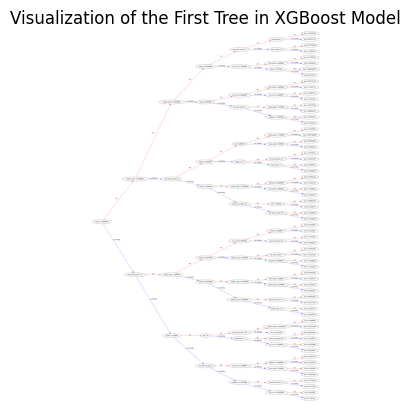

In [17]:
import matplotlib.pyplot as plt
from xgboost import plot_tree, XGBRegressor

# Misalnya, kita telah melatih model XGBoost
# model = XGBRegressor(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

# Visualisasi struktur pohon pertama
plt.figure(figsize=(20, 10))
plot_tree(model, num_trees=0, rankdir='LR')  # num_trees=0 memilih pohon pertama
plt.title("Visualization of the First Tree in XGBoost Model")
plt.show()


Visualisasi struktur pohon XGBoost menunjukkan detail bagaimana model membuat keputusan untuk memprediksi nilai target. Setiap node di pohon merepresentasikan kondisi split berdasarkan fitur tertentu dan nilai split, sedangkan cabang menunjukkan keputusan yang diambil berdasarkan kondisi tersebut. Daun (leaf nodes) menampilkan hasil prediksi. Visualisasi ini membantu memahami logika model dan memberikan transparansi tentang bagaimana model menggunakan fitur-fitur untuk membuat prediksi.

# Learning Curve

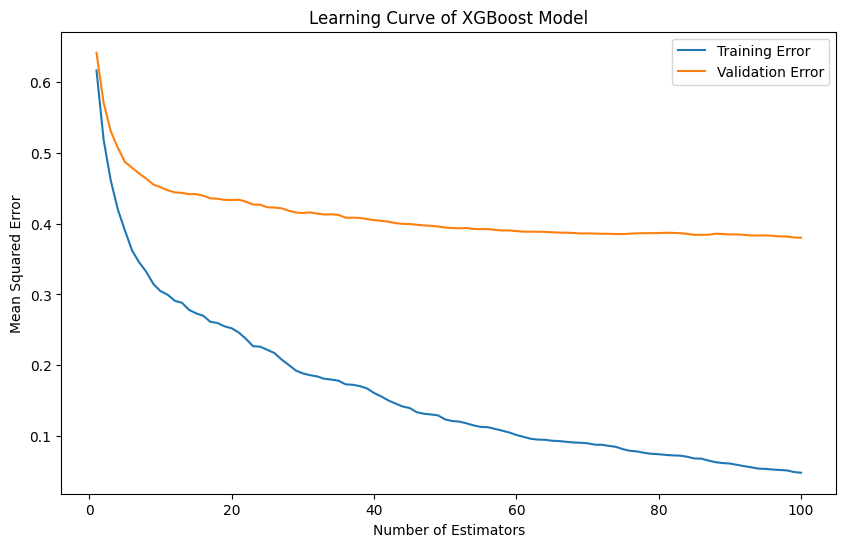

In [18]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Membagi data menjadi set pelatihan dan validasi
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Menyimpan metrik error untuk setiap tahap pelatihan
train_errors = []
valid_errors = []

# Membuat model XGBRegressor dan melatih model dengan n_estimators bertambah secara bertahap
for n_estimators in range(1, 101):  # Ubah rentang sesuai kebutuhan
    model = XGBRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)

    # Memprediksi dan menghitung error untuk set pelatihan dan validasi
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)

    train_errors.append(mean_squared_error(y_train, train_pred))
    valid_errors.append(mean_squared_error(y_valid, valid_pred))

# Visualisasi learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), train_errors, label="Training Error")
plt.plot(range(1, 101), valid_errors, label="Validation Error")
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve of XGBoost Model")
plt.legend()
plt.show()


Learning curve menunjukkan performa model XGBoost pada data training dan validation seiring dengan peningkatan ukuran data pelatihan. Grafik ini membantu mengevaluasi apakah model mengalami overfitting atau underfitting. Jika training error rendah tetapi validation error tinggi, model kemungkinan overfitting. Jika baik training maupun validation error tinggi, model mungkin underfitting. Grafik juga memberikan wawasan tentang kapan model stabil dan kapan penambahan data tidak lagi memberikan peningkatan signifikan, membantu dalam menentukan ukuran dataset yang optimal.

# Shap Values

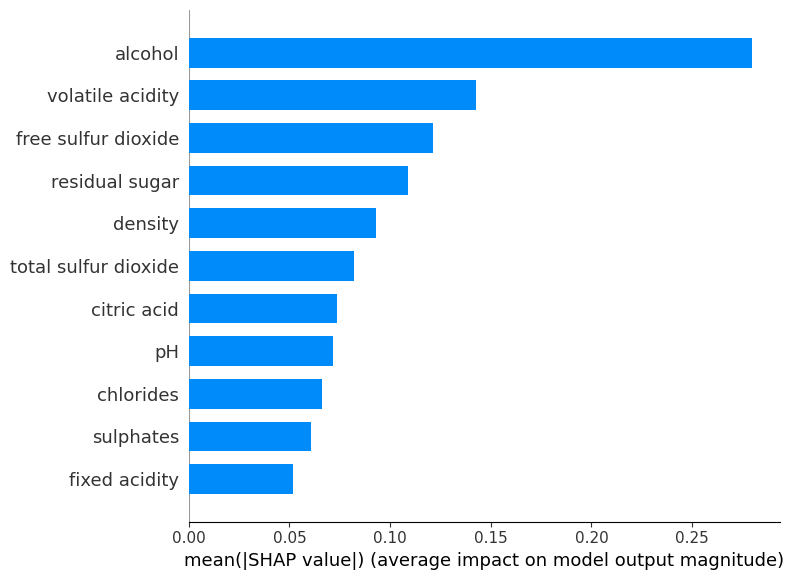

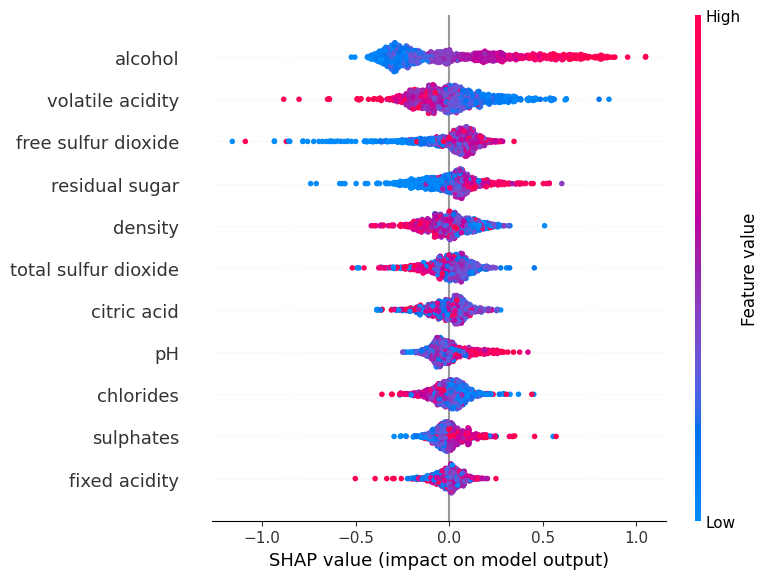

In [19]:
import shap
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Membagi data menjadi set pelatihan dan validasi
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Melatih model XGBoost
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Menginisialisasi objek SHAP dan menghitung SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)

# Summary plot untuk visualisasi SHAP values
shap.summary_plot(shap_values, X_valid, plot_type="bar", show=True)
shap.summary_plot(shap_values, X_valid, show=True)


Visualisasi SHAP values memberikan gambaran tentang seberapa besar dan ke arah mana setiap fitur memengaruhi prediksi model XGBoost. Dalam summary plot SHAP, setiap titik mewakili satu pengamatan untuk satu fitur, dengan sumbu horizontal menunjukkan dampak fitur pada prediksi, dan warna titik menunjukkan nilai fitur (rendah hingga tinggi). Plot ini membantu mengidentifikasi fitur mana yang paling berpengaruh dan bagaimana mereka berkontribusi (positif atau negatif) terhadap prediksi, memberikan transparansi dan interpretabilitas yang penting dalam model machine learning kompleks.

# Partial Dependence Plot

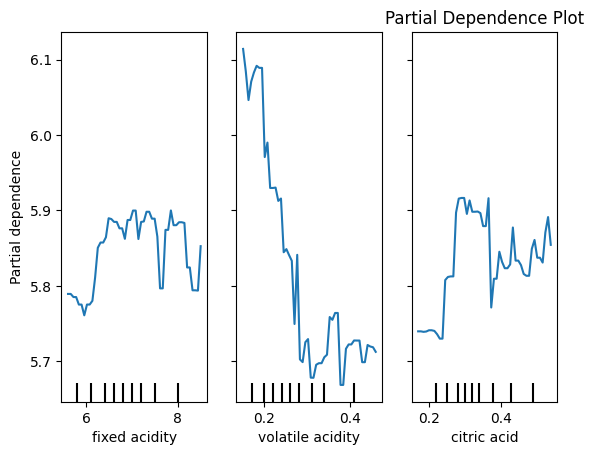

In [21]:
from sklearn.inspection import PartialDependenceDisplay

# Menampilkan Partial Dependence Plot untuk beberapa fitur
features_to_plot = [0, 1, 2]  # Indeks fitur yang ingin dipetakan
PartialDependenceDisplay.from_estimator(
    model,
    X_val,
    features=features_to_plot,
    grid_resolution=50  # Resolusi grid untuk plot
)
plt.title("Partial Dependence Plot")
plt.show()


Hal ini dapat dijelaskan oleh persepsi umum bahwa kadar alkohol yang lebih tinggi memberikan karakteristik tubuh anggur yang lebih kuat. Di sisi lain, fitur seperti 'residual sugar' mungkin menunjukkan sedikit peningkatan pada kualitas, meskipun pengaruhnya cenderung bervariasi tergantung pada jenis anggur. Fitur 'density' sering berkolerasi erat dengan kandungan gula dan alkohol, yang berarti bahwa perubahan kecil pada kepadatan juga dapat memberikan dampak tidak langsung pada persepsi kualitas, meskipun kontribusinya dalam model mungkin tidak dominan. Secara keseluruhan, analisis PDP ini membantu dalam memahami bagaimana setiap fitur mempengaruhi prediksi model secara individual, memberikan panduan untuk fokus pada karakteristik yang benar-benar berperan dalam kualitas anggur.